In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from pystk2_gymnasium import AgentSpec
from pystk2_gymnasium.envs import STKRaceEnv
from pystk2_gymnasium.stk_wrappers import ConstantSizedObservations, DiscreteActionsWrapper
from pystk2_gymnasium.wrappers import FlattenerWrapper, SpaceFlattener
from pystk2_gymnasium.definitions import ActionObservationWrapper
from test_ai import ActionOnlyFlattenerWrapper

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
import gymnasium as gym
from pystk2_gymnasium import AgentSpec
from tqdm import tqdm
import numpy as np

In [64]:
state_mean = torch.tensor([0.71151, 0.0, -0.061457, -0.10169, 3.4319, -0.52413, 661.15, 0.42724, 2.7327e-05, 3.1487e-05, 0.71825, -0.018171, -0.021021, 43.886, -0.0085404, -0.0041873, 51.719, -0.0010554, -0.0016169, 62.018, -0.006209, -0.00017353, 84.65, -0.0022044, -0.05316, 94.29, -0.000844, 0.014244, 31.789, -0.051845, 0.05947, 50.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.091044, 657.46, 665.37, 660.0, 667.5, 661.4, 668.77, 662.42, 669.61, 663.63, 670.71, 0.026151, 0.041322, 7.6908, 0.012883, 0.0072263, 14.788, 0.0044946, -0.0027369, 21.985, -0.0037865, -0.0051671, 28.917, -0.010331, -0.0035413, 35.536, 0.07285, 0.069774, 6.6553, 0.023434, 0.04203, 8.1486, 0.011373, 0.0085714, 15.25, 0.0030726, -0.0013871, 22.422, -0.0040406, -0.0039074, 29.326, 10.412, 10.378, 10.354, 10.331, 10.314, 0.048839, 1.0454, -0.005195, 0.018967, 21.373])
state_std  = torch.tensor([3.5549, 1.0, 1.6011, 1.7763, 10.69, 11.215, 512.81, 0.70422, 0.021198, 0.027364, 0.07953, 0.73691, 0.40548, 35.889, 0.75692, 0.4407, 36.7, 0.83793, 0.53804, 43.32, 1.0244, 0.72855, 48.63, 1.1039, 0.83519, 48.809, 1.572, 1.6809, 26.944, 2.1913, 2.4827, 36.348, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.084412, 512.98, 512.19, 511.66, 510.81, 509.95, 509.12, 508.47, 507.75, 507.13, 506.41, 0.7026, 0.58222, 14.014, 0.46184, 0.46873, 17.612, 0.43538, 0.4327, 21.155, 0.45335, 0.42052, 24.391, 0.49166, 0.42006, 27.216, 2.4385, 2.7218, 14.038, 0.70692, 0.58753, 17.399, 0.46856, 0.47626, 20.34, 0.44233, 0.44088, 23.3, 0.46, 0.42836, 26.018, 2.8646, 2.853, 2.8597, 2.8823, 2.9084, 0.58635, 0.22906, 1.3934, 1.5918, 7.0388])

def state_to_tensor(state):

    continuous_vars = ['attachment_time_left', 'center_path', 'center_path_distance', 'distance_down_track', 'energy', 'front', 'items_position', 'karts_position', 'max_steer_angle', 'paths_distance', 'paths_end', 'paths_start', 'paths_width', 'shield_time', 'skeed_factor', 'velocity']

    continuous_state = []
    for key in continuous_vars:
        value = state[key]
        num_envs = value.shape[0]
        if key in ['items_position', 'paths_end', 'paths_start', 'paths_width']:
            normalized_value = value[..., :5, :]
        else:    
            # normalized_value = (value - self.means[key]) / self.stds[key]
            normalized_value = value
            
        continuous_state.append(normalized_value.reshape(num_envs, -1))

    continuous_state = np.concatenate(continuous_state, axis=-1)
    state = torch.tensor(continuous_state)

    return state

In [65]:
class MLPWithMultipleHeads(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dims):
        super(MLPWithMultipleHeads, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.heads = nn.ModuleList([
            # nn.Linear(hidden_dim, out_dim)
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, out_dim),
            )
            for out_dim in output_dims])
        
        
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, action=None):
        shared_output = self.shared_layers(x)
        action_logits = [head(shared_output) for head in self.heads]
        

        dists = [Categorical(logits=action_logits[i]) for i in range(len(action_logits))]

        if action is None:
            action = torch.stack([dist.sample() for dist in dists], dim=-1)
        
        log_ps = [F.log_softmax(action_logits[i], dim=-1).gather(-1, action[:, i].unsqueeze(-1)).squeeze(-1) for i in range(len(self.heads))]
        log_p = torch.stack(log_ps, dim=-1).sum(dim=-1)
        
        value = self.critic(x)
        
        entropy = sum([dist.entropy().mean() for dist in dists])
        
        return action, log_p, value, entropy


# model = MLPWithMultipleHeads(134, 256, [5, 2, 2, 2, 2, 2, 7])

# x = torch.rand((777, 134))
# action, log_p, value, entropy = model(x)
# new_action, new_log_p, new_value, _ = model(x, action=action)

In [66]:
def compute_gae_parallel(dones, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert (
        dones.shape == rewards.shape == values.shape == next_values.shape
    ), "All inputs must have the same shape (num_envs, sequence_length)."

    num_envs, seq_len = dones.shape
    advantages = torch.zeros_like(rewards, dtype=torch.float32)
    returns = torch.zeros_like(rewards, dtype=torch.float32)
    last_advantage = torch.zeros(num_envs, dtype=torch.float32)
    last_return = torch.zeros(num_envs, dtype=torch.float32)

    for t in reversed(range(seq_len)):
        mask = 1.0 - dones[:, t]
        last_value = next_values[:, t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[:, t] + gamma * last_value - values[:, t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[:, t] + gamma * last_return

        advantages[:, t] = last_advantage
        returns[:, t] = last_return

    return advantages, returns

In [150]:
def collect_trajectories(env, state, model, n_steps):

    states, actions, rewards, log_ps, state_values, dones = [], [], [], [], [], []

    # state, _ = env.reset()
    

    total_reward = 0
    step_count = 0

    for _ in tqdm(range(n_steps)):
        state = state_to_tensor(state)
        action, log_p, state_value, entropy = model(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_ps.append(log_p)
        state_values.append(state_value)
        dones.append(done * 1.)

        
        # if any(done):
        #     # print(done)
        #     # Manually reset done environments if needed
        #     for i in range(len(done)):
        #         if done[i]:
        #             new_state, _ = env.envs[i].reset()
        #             next_state[i] = new_state
                    
        state = next_state
        total_reward += reward
        step_count += 1
                    
    
    next_state = state_to_tensor(next_state)
    # print(next_state.shape)
    next_value = model.critic(next_state).squeeze(-1)
    
    states = torch.stack(states)
    actions = torch.stack(actions)
    rewards = torch.tensor(rewards)
    state_values = torch.stack(state_values).squeeze(-1)
    dones = torch.tensor(dones)

    next_state_values = torch.concatenate((state_values[1:], next_value.unsqueeze(0)), dim=0)
    
    # advantages, returns = compute_gae(dones, rewards, state_values, next_state_values)
    advantages, returns = compute_gae_parallel(dones, rewards, state_values, next_state_values)
         
    # Normalize advantages
    # advantages = torch.FloatTensor(advantages)
    returns = advantages + state_values
            
    trajectories = {
        "states" : states.reshape(-1, 121).detach(),
        "actions" : actions.reshape(-1, 7).detach(),
        "rewards" : rewards.reshape(-1).detach(),
        "dones" : dones.reshape(-1).detach(),
        "log_ps" : torch.stack(log_ps).reshape(-1).detach(),
        "state_values": state_values.reshape(-1).detach(),
        "next_state_values": next_state_values.reshape(-1).detach(),
        "returns" : returns.reshape(-1).detach(),
        "advantages" : advantages.reshape(-1).detach(),
    }
    
    return trajectories, state


# trajectories = collect_trajectories(env, model, n_steps=128)

# for key in trajectories:
#     print(key, trajectories[key].shape)

def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

# shuffled_trajectories = shufffle_trajectory(trajectories)

In [104]:
# num_envs = 8
# env = gym.vector.SyncVectorEnv([
#     lambda: gym.make("supertuxkart/flattened_multidiscrete-v0", render_mode=None, agent=AgentSpec(use_ai=True))
#     for _ in range(num_envs)
# ])                                  

# state, _ = env.reset()                                  

In [105]:
def ppo_optimization(trajectories, model, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            state = traj_states[batch_size*i:batch_size*(i+1)]
            action = traj_actions[batch_size*i:batch_size*(i+1)]
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)]
            return_ = traj_returns[batch_size*i:batch_size*(i+1)]
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)]
            
            new_action, new_log_p, new_state_value, entropy = model(state, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
                    
            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)

            value_loss = ((return_ - new_state_value)**2).mean()

            loss = policy_loss - 1e-5*entropy.mean() + 0.5*value_loss

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)

In [106]:
class ActionOnlyFlattenerWrapper(ActionObservationWrapper):
    """Flattens actions and observations."""

    def __init__(self, env: gym.Env):
        super().__init__(env)

        self.action_flattener = SpaceFlattener(env.action_space)
        self.action_space = self.action_flattener.space
        
    def observation(self, observation):
        return observation


    def action(self, action):
        discrete_actions = {}
        if not self.action_flattener.only_continuous:
            actions = (
                action if self.action_flattener.only_discrete else action["discrete"]
            )
            assert len(self.action_flattener.discrete_keys) == len(actions), (
                "Not enough discrete values: "
                f"""expected {len(self.action_flattener.discrete_keys)}, """
                f"""got {len(action)}"""
            )
            discrete_actions = {
                key: key_action
                for key, key_action in zip(self.action_flattener.discrete_keys, actions)
            }

        continuous_actions = {}
        if not self.action_flattener.only_discrete:
            actions = (
                action
                if self.action_flattener.only_continuous
                else action["continuous"]
            )
            continuous_actions = {
                key: actions[
                    self.action_flattener.indices[ix] : self.action_flattener.indices[
                        ix + 1
                    ]
                ].reshape(shape)
                for ix, (key, shape) in enumerate(
                    zip(
                        self.action_flattener.continuous_keys,
                        self.action_flattener.shapes,
                    )
                )
            }

        return {**discrete_actions, **continuous_actions}



In [107]:
# env = STKRaceEnv(agent=AgentSpec(use_ai=False), render_mode=None)
# env = gym.wrappers.PassiveEnvChecker(env)
# env = gym.wrappers.OrderEnforcing(env)
# env = gym.wrappers.TimeLimit(env, max_episode_steps=1500)
# env = ConstantSizedObservations(env, state_paths=20, state_items=20)
# env = DiscreteActionsWrapper(env)
# env = ActionOnlyFlattenerWrapper(env)

In [147]:
num_envs = 1

def make_env():
    env = STKRaceEnv(agent=AgentSpec(use_ai=False), render_mode="human")
    env = gym.wrappers.PassiveEnvChecker(env)
    env = gym.wrappers.OrderEnforcing(env)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=1500)
    env = ConstantSizedObservations(env, state_paths=20, state_items=20)
    env = DiscreteActionsWrapper(env)
    env = ActionOnlyFlattenerWrapper(env)
    return env

env = gym.vector.SyncVectorEnv([
    lambda: make_env()
    for _ in range(num_envs)
])

init_state, _ = env.reset()
last_state = init_state


from types import MethodType

def modified_get_state(self, kart_ix: int, use_ai: bool):
        kart = self.world.karts[kart_ix]
        terminated = kart.has_finished_race

        # Get the observation and update the world state
        obs = self.get_observation(kart_ix, use_ai)

        d_t = max(0, kart.overall_distance)
        f_t = 1 if terminated else 0
        reward = (
            (d_t - self.last_overall_distances[kart_ix]) / 10.0
            # + (1.0 - kart.position / self.num_kart) * (3 + 7 * f_t)
            # - 0.1
            # + 10 * f_t
        )
        return (
            obs,
            reward,
            terminated,
            {
                "position": kart.position,
                "distance": d_t,
            },
        )

for i in range(len(env.envs)):
    env.envs[i].unwrapped.get_state = MethodType(modified_get_state, env.envs[0].unwrapped)

..:: Antarctica Rendering Engine 2.0 ::..


In [148]:
model = MLPWithMultipleHeads(
    input_dim=121,
    hidden_dim=512,
    output_dims=[5, 2, 2, 2, 2, 2, 7]
)
model.load_state_dict(torch.load('models/behavioral_cloning.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/tmp/ipykernel_13285/235525333.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/behavioral_cloning.pt'))


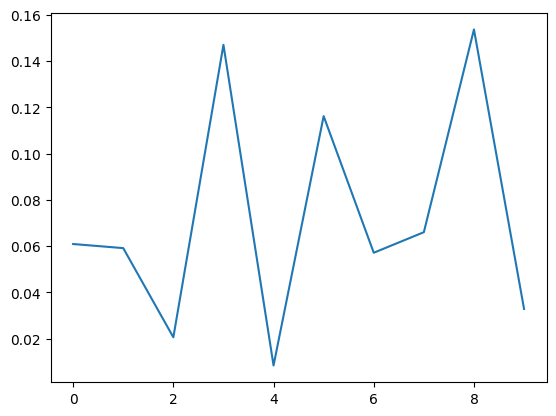

 32%|███▏      | 320/1000 [00:04<00:09, 68.14it/s]


KeyboardInterrupt: 

In [151]:

rewards = []
for step in range(1000):
    trajectories, last_state = collect_trajectories(env, last_state, model, n_steps=1000)
    shuffled_trajectory = shufffle_trajectory(trajectories)
    ppo_optimization(shuffled_trajectory, model, optimizer, epochs=4, batch_size=256)
    
    rewards.append(trajectories['rewards'].mean().item())
    
    
    if step % 1 == 0:
        clear_output(True)
        plt.plot(rewards)
        plt.show()

In [40]:
env.close()